# Testing ClusterDE - Optimized null data

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.ClusterDE as cd

import warnings
warnings.filterwarnings("ignore")

/var/folders/c0/fpqfgc2s7f76rlp41vv8hxy1h1ttxs/T/ipykernel_5735/2862039534.py:18: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_nb_est.h5ad")


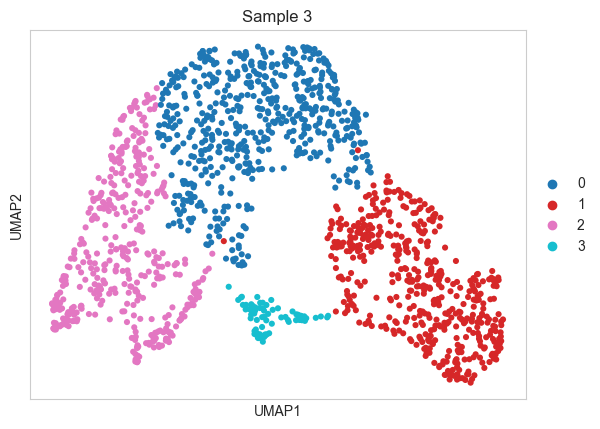

In [4]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

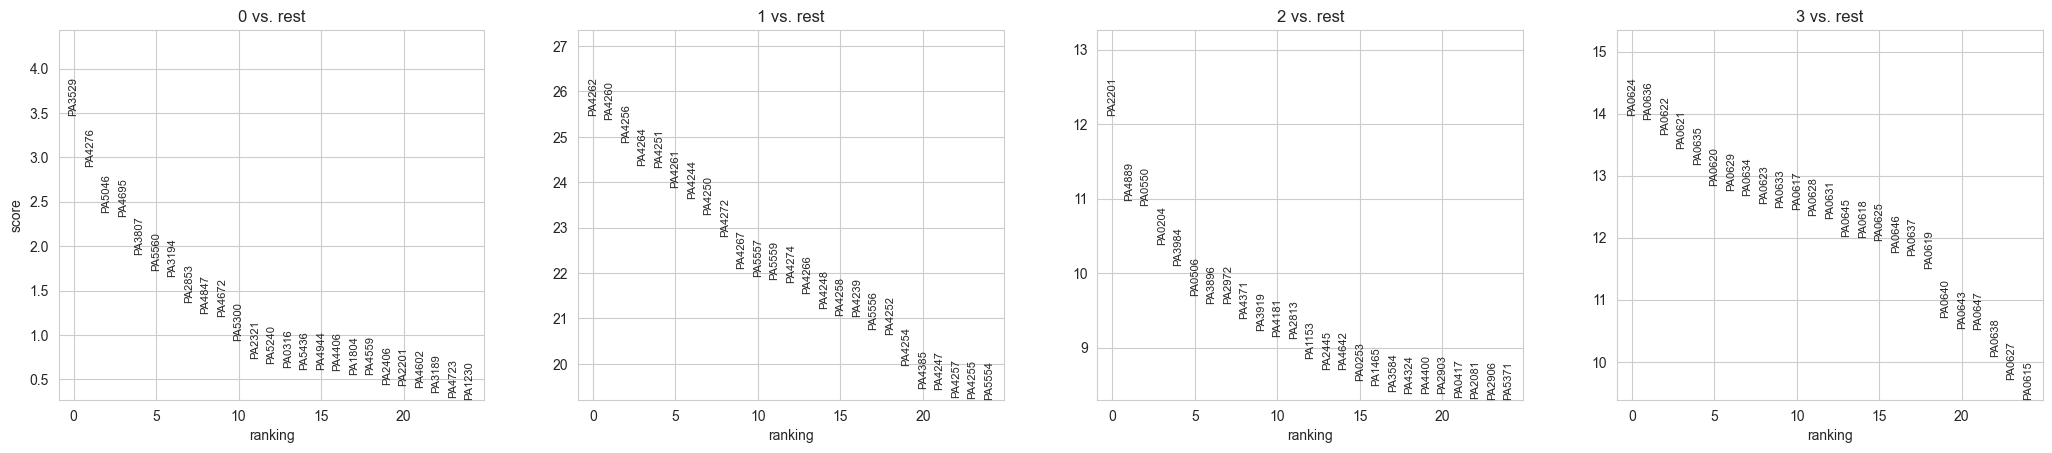

In [5]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

### Load and process null data

In [31]:
data_null_gen = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/S3_null_data_opt.h5ad")

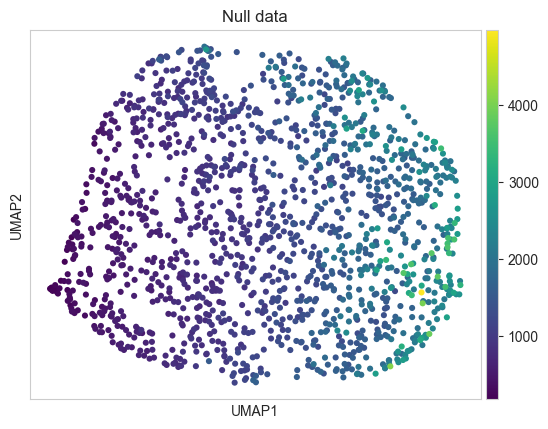

In [32]:

sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [33]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()


In [34]:
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.6684948202315661
Cluster 1 - DE genes: 54; Minimum q value: 0.02564102564102564
Cluster 2 - DE genes: 47; Minimum q value: 0.02564102564102564
Cluster 3 - DE genes: 0; Minimum q value: 0.15384615384615385


In [35]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene.var[f"DE_cluster_{c}_gen"] = (data_gene.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.08333333333333333
Cluster 1 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 2902; Minimum q value: 0.03225806451612903
Cluster 3 - DE genes: 0; Minimum q value: 1.0


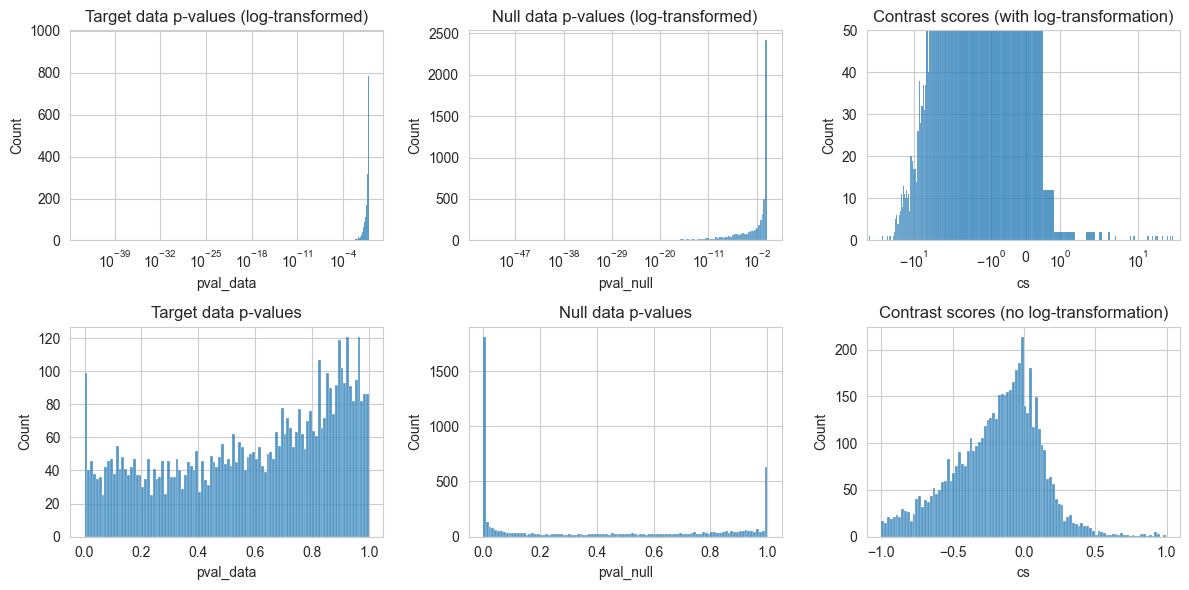

In [36]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

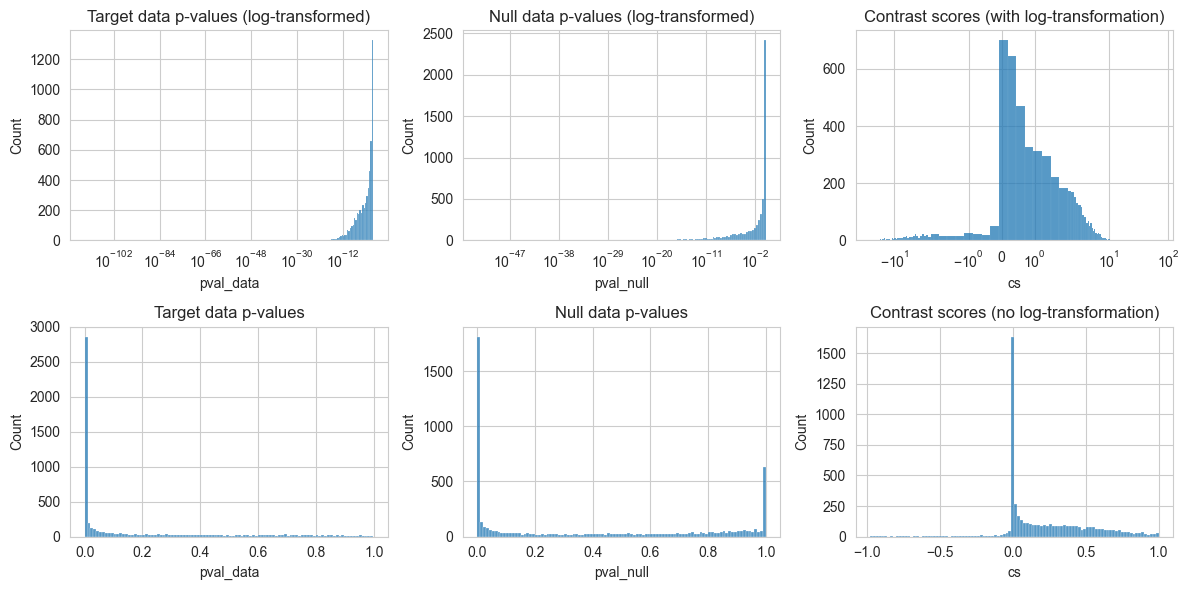

In [37]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [38]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA4255,5.606549e-14,1.062677e-03,13.251304,2.973599,10.277706,0.668495
PA0636,3.708294e-09,8.645779e-01,8.430826,0.063196,8.367630,0.668495
PA0631,4.372624e-09,8.459665e-01,8.359258,0.072647,8.286611,0.668495
PA4261,6.799844e-11,8.306118e-03,10.167501,2.080602,8.086899,0.668495
PA0620,4.295316e-09,3.383576e-01,8.367005,0.470624,7.896381,0.668495
...,...,...,...,...,...,...
PA5049,4.971858e-01,1.426833e-30,0.303481,29.845627,-29.542146,1.000000
PA1074,6.125081e-03,9.654659e-34,2.212888,33.015263,-30.802375,1.000000
PA5490,2.076414e-02,6.683818e-34,1.682686,33.174975,-31.492289,1.000000


In [39]:
pvals_log_gen["3"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA0624,2.354790e-44,9.008826e-01,43.628048,0.045332,43.582716,0.153846
PA0636,6.161842e-44,8.645779e-01,43.210289,0.063196,43.147094,0.153846
PA0622,1.946223e-42,7.922747e-01,41.710807,0.101124,41.609683,0.153846
PA0621,4.073517e-41,6.893308e-01,40.390030,0.161572,40.228458,0.153846
PA0635,1.254658e-39,4.279138e-01,38.901475,0.368644,38.532831,0.153846
...,...,...,...,...,...,...
PA5049,4.892274e-01,1.426833e-30,0.310489,29.845627,-29.535138,1.000000
PA5490,3.794800e-02,6.683818e-34,1.420811,33.174975,-31.754164,1.000000
PA3189,3.342113e-02,2.601110e-34,1.475979,33.584841,-32.108862,1.000000


SignificanceResult(statistic=0.9999999882614878, pvalue=0.0)
[[1.         0.63473297]
 [0.63473297 1.        ]]


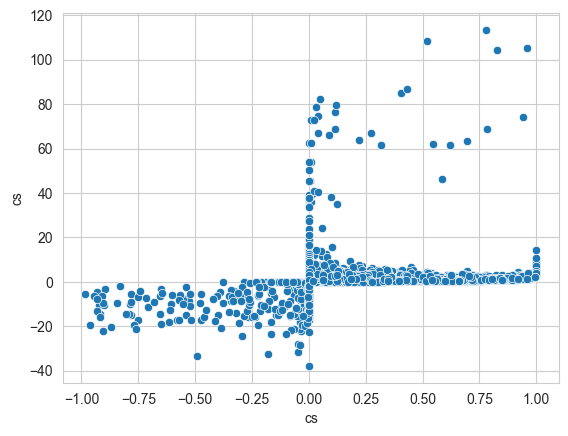

In [40]:
sns.scatterplot(x = pvals_gen["2"]["cs"], y = pvals_log_gen["2"]["cs"])

from scipy.stats import spearmanr
print(spearmanr(pvals_gen["2"]["cs"], pvals_log_gen["2"]["cs"]))
print(np.corrcoef(pvals_gen["2"]["cs"], pvals_log_gen["2"]["cs"]))


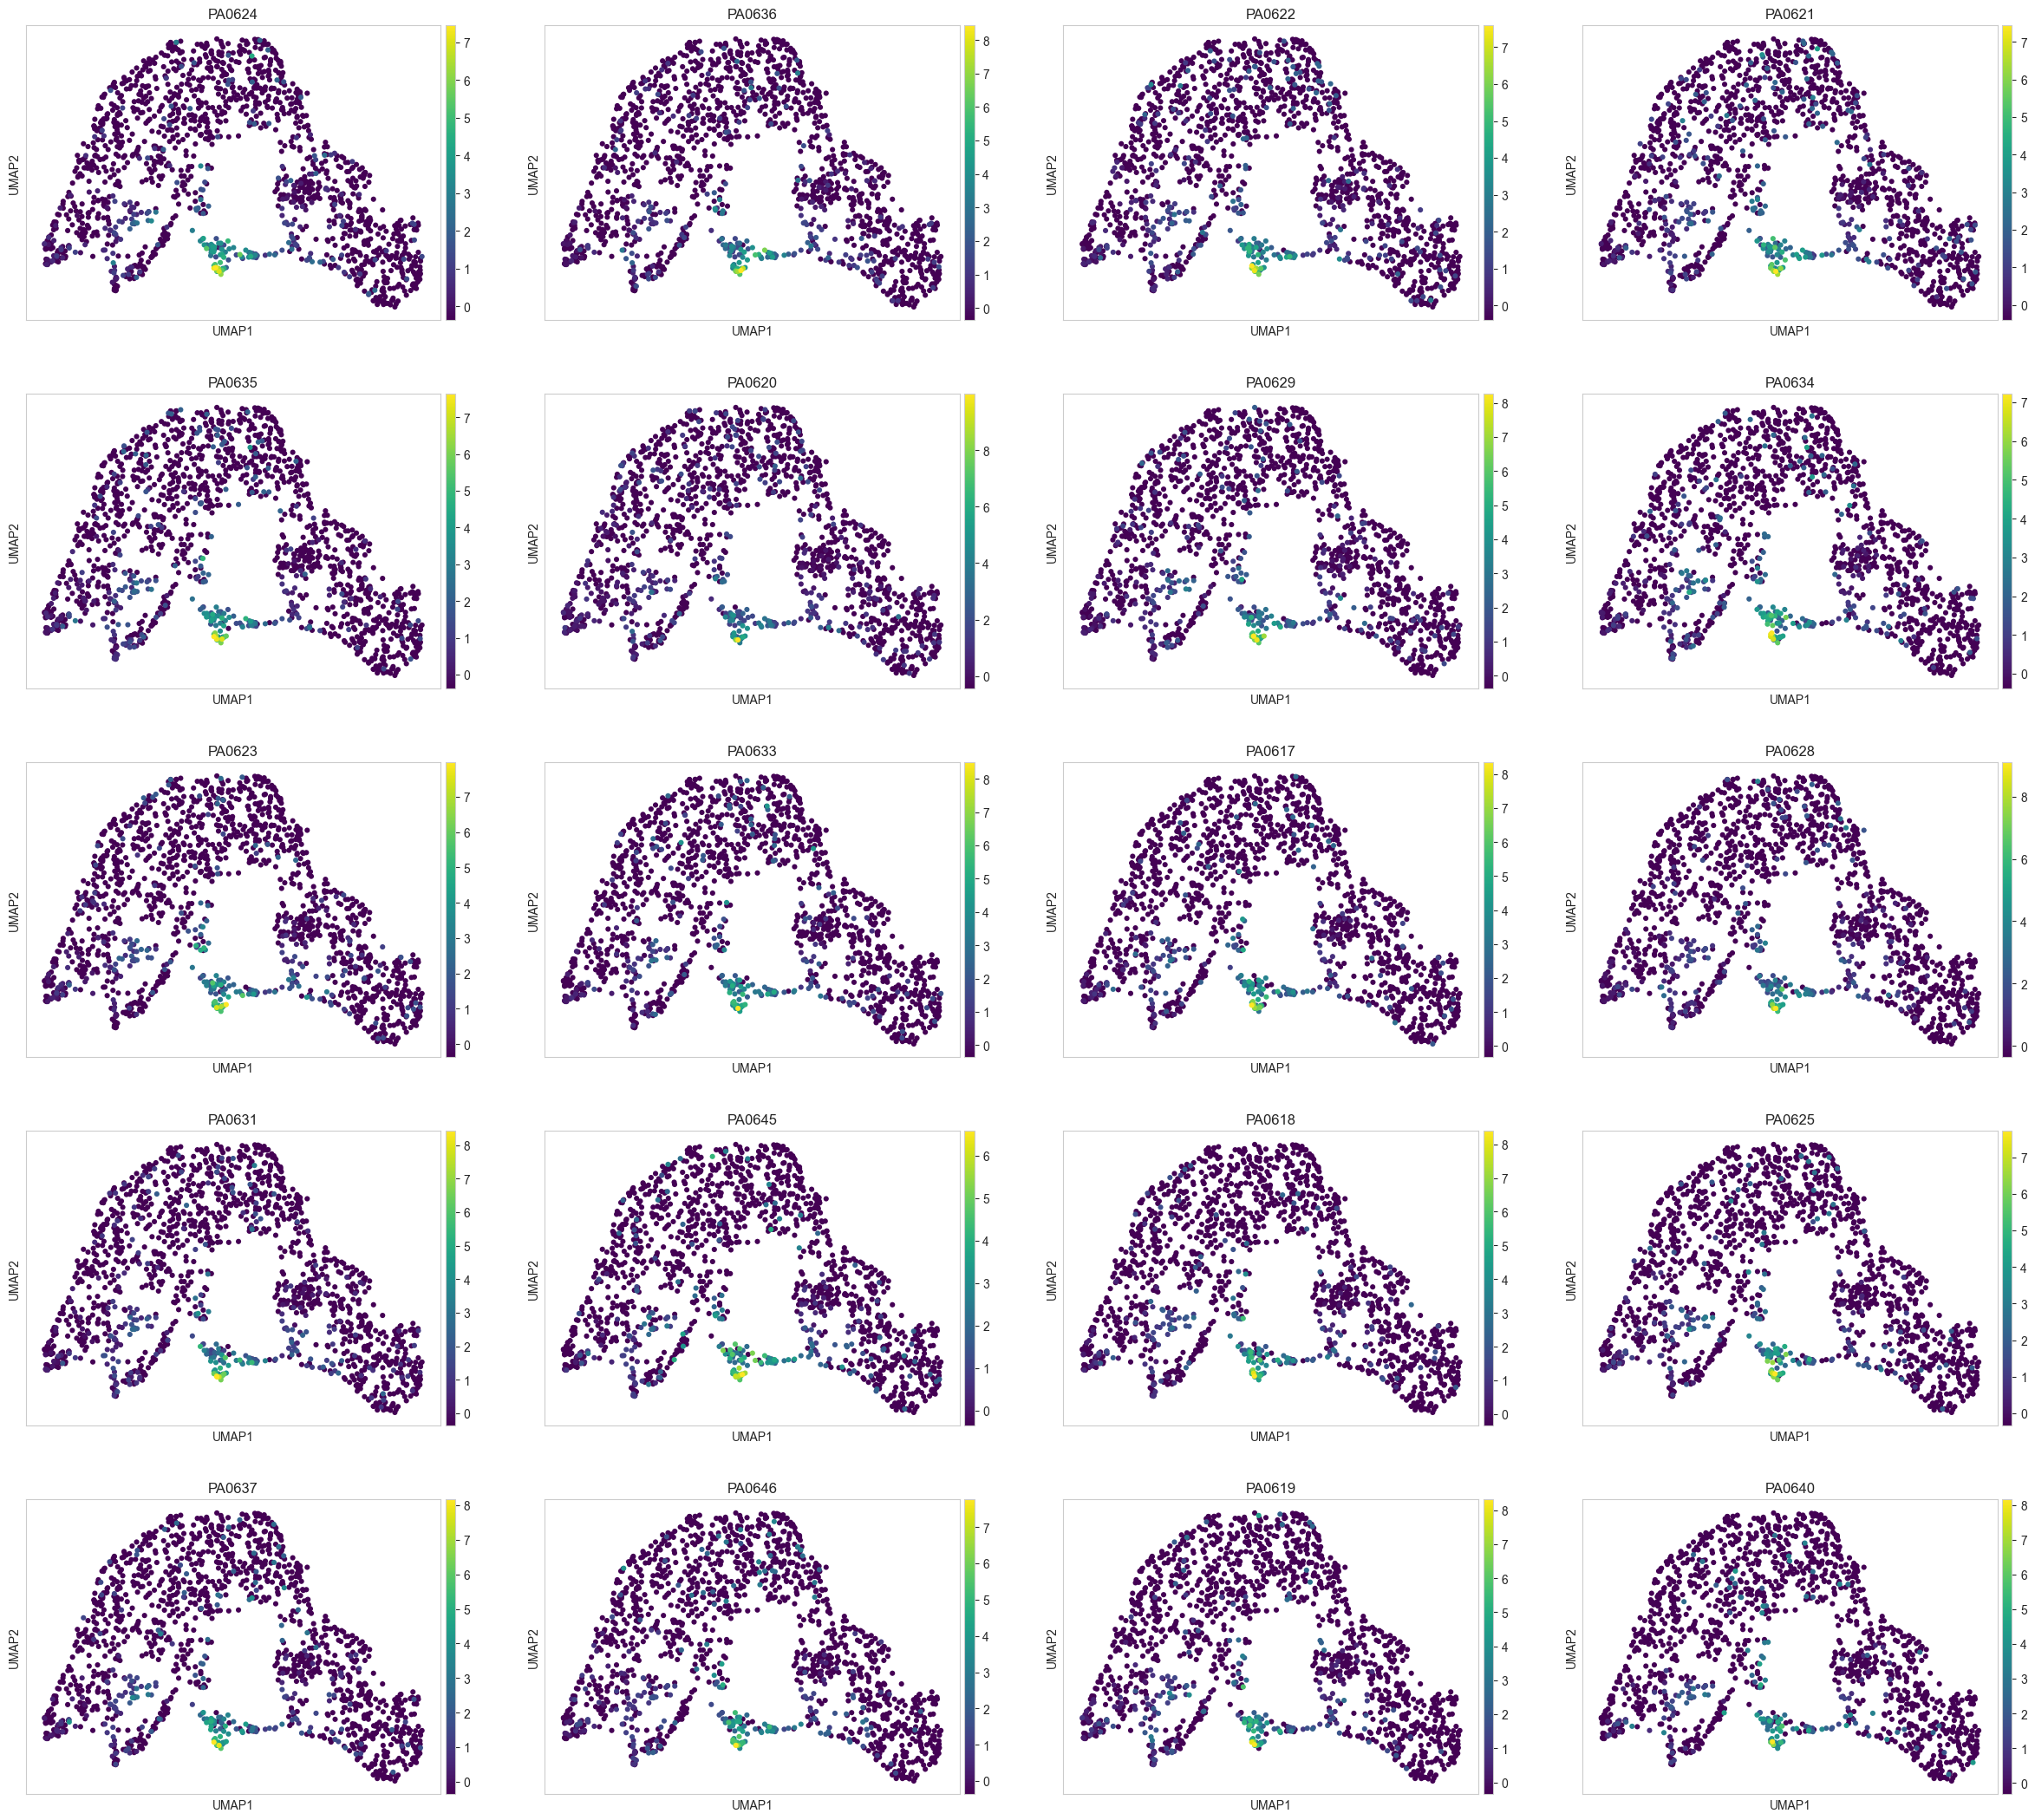

In [41]:
sc.pl.umap(data_gene, color=pvals_log_gen["3"].sort_values("q", ascending=True).index.tolist()[:20], cmap="viridis")


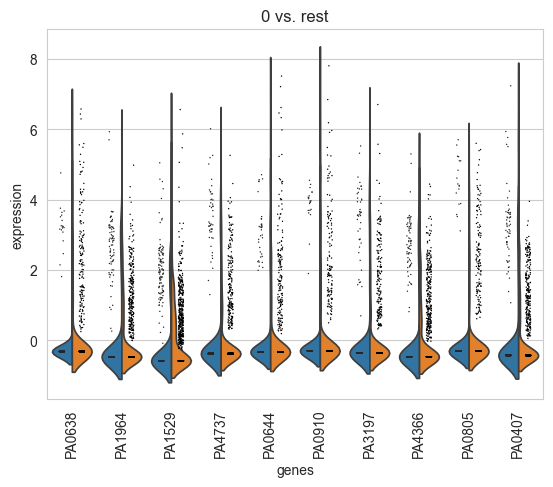

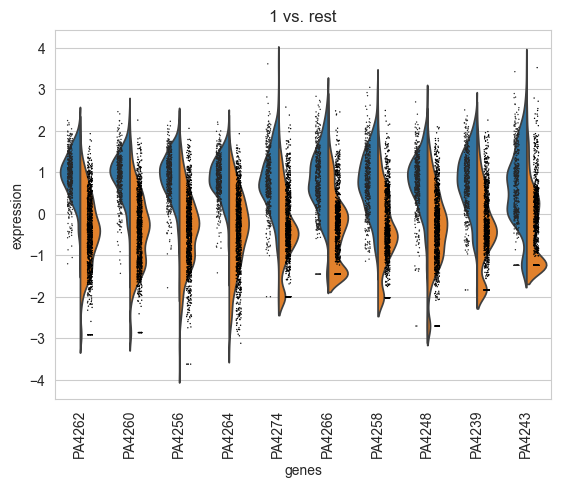

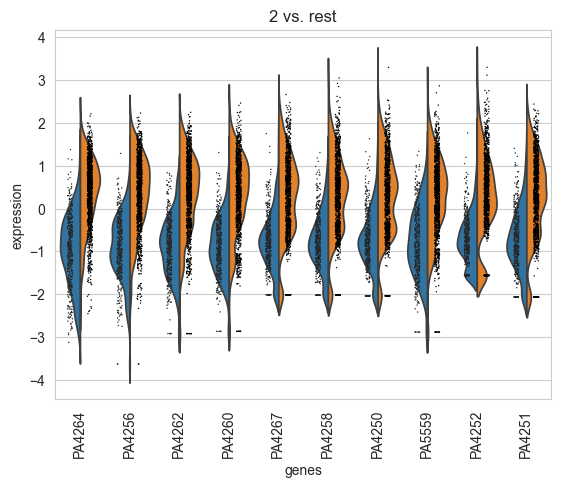

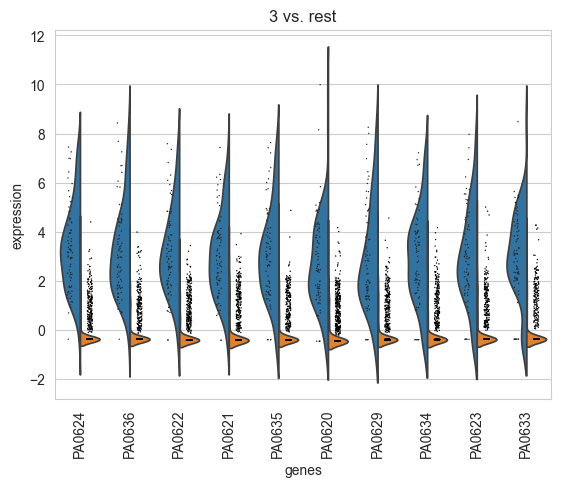

In [42]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), gene_names=pvals_log_gen[str(i)].sort_values("q", ascending=True).index.tolist()[:10])

In [30]:
pvals_log_gen["3"].to_csv("pvals_3.csv")